# CITS3401 Project 2 Report
## Eddie Atkinson (22487668)

## Introduction
The purpose of the previous exercise was to produce clean, aggregated data and load it into a database where it could be efficiently queried, manipulated and visualised. This component of the project is focused on analysing that data to discover useful and previous unknown trends and patterns using a variety of techniques, including association rule mining, classification, numerosity reduction, and machine learning.

## Initial Data Cleaning
Data is stored in the database in normalised tables as part of its snowflake schema. In order to perform analytics on the data it is necessary to denormalise the data, remerging it into a central dataframe. The data used for this analysis is contained in the CSV files that were used to load the data in to database in the first place, however it is easy to imagine a situation where data would be exported in bulk from MSSQL to CSVs using the export wizard.   

To start the data must be loaded into dataframes, remembering that the "~" separator was used on the data for ease of use in the SQL loading scripts:

In [65]:
import pandas as pd

dim_country = pd.read_csv("data/dim_country.csv", sep="~")
dim_education = pd.read_csv("data/dim_education.csv", sep="~")
dim_person = pd.read_csv("data/dim_person.csv", sep="~")
dim_race = pd.read_csv("data/dim_race.csv", sep="~")
dim_relationship = pd.read_csv("data/dim_relationship.csv", sep="~")
dim_work = pd.read_csv("data/dim_work.csv", sep="~")
fact_income = pd.read_csv("data/fact_income.csv", sep="~")

# Have a look at some of the dataframes to check the reading was successful
print(fact_income.head())
print(dim_person.head())

   person_id  capital_gain  capital_loss  hours_pw
0          0          2174             0        40
1          1             0             0        38
2          2             0             0        65
3          3             0             0        37
4          4             0             0        40
   person_id  race_id  country_id  work_id  education_id  relationship_id  \
0          0        0           0        0             0                0   
1          1        0           0        0             0                0   
2          2        0           0        0             0                0   
3          3        0           0        0             0                0   
4          4        0           0        0             0                0   

  gender income_bracket  age  
0      M          <=50K   39  
1      M          <=50K   37  
2      F          <=50K   24  
3      M          <=50K   32  
4      M          <=50K   44  


To demerge the data a central dataframe is incrementally constructed by merging the dataframes on their ID columns and then removing the ID columns from the data set. We'll start by constructing the central dataframe by merging ```dim_person``` with ```fact_income```. 

In [66]:
central_df = fact_income
central_df = central_df.merge(dim_person, on=["person_id"], how="left")
# Drop the person ID, it is no longer needed
central_df.drop(["person_id"], axis=1, inplace=True)
# Have a look at the dataframe to check all went well
print(central_df.head())

   capital_gain  capital_loss  hours_pw  race_id  country_id  work_id  \
0          2174             0        40        0           0        0   
1             0             0        38        0           0        0   
2             0             0        65        0           0        0   
3             0             0        37        0           0        0   
4             0             0        40        0           0        0   

   education_id  relationship_id gender income_bracket  age  
0             0                0      M          <=50K   39  
1             0                0      M          <=50K   37  
2             0                0      F          <=50K   24  
3             0                0      M          <=50K   32  
4             0                0      M          <=50K   44  


Now that the central, remerged dataframe has been created, the rest of the dimensions can be merged into it following the same pattern of merging based on IDs followed by ID deletion.

In [67]:
# Process dim_country
central_df = central_df.merge(dim_country, on=["country_id"], how="left")
# Delete country ID
central_df.drop(["country_id"], axis=1, inplace=True)

# Process dim_education
central_df = central_df.merge(dim_education, on=["education_id"], how="left")
# Delete education ID
central_df.drop(["education_id"], axis=1, inplace=True)

# Process dim_race
central_df = central_df.merge(dim_race, on=["race_id"], how="left")
central_df.drop(["race_id"], axis=1, inplace=True)

# Process dim_relationship
central_df = central_df.merge(dim_relationship, on=["relationship_id"], how="left")
central_df.drop(["relationship_id"], axis=1, inplace=True)

# Process dim_work
central_df = central_df.merge(dim_work, on=["work_id"], how="left")
central_df.drop(["work_id"], axis=1, inplace=True)

# Take a final peek at the dataset to check that it's correct
print(central_df.head())

   capital_gain  capital_loss  hours_pw gender income_bracket  age  \
0          2174             0        40      M          <=50K   39   
1             0             0        38      M          <=50K   37   
2             0             0        65      F          <=50K   24   
3             0             0        37      M          <=50K   32   
4             0             0        40      M          <=50K   44   

    country_name  education ethnicity relationship_role marital_relationship  \
0  United-States  Bachelors     White     Not-in-family        Never-married   
1  United-States  Bachelors     White     Not-in-family        Never-married   
2  United-States  Bachelors     White     Not-in-family        Never-married   
3  United-States  Bachelors     White     Not-in-family        Never-married   
4  United-States  Bachelors     White     Not-in-family        Never-married   

  marriage_status work_class    occupation  
0     Not Married  State-gov  Adm-clerical  
1     No

Now that the data has been remerged we can perform analytics. Let's start with association rule mining. 

## Assocation Rule Mining

Association rule mining is concerned with finding frequent itemsets. Association rule mining could be helpful in the context of this dataset for finding out which characteristics are associated with being in a higher income bracket, so that people wishing to increase their income can make data-driven decisions about how to do so. 

Whether an itemset is considered frequent is determined by its support - its relative frequency in the dataset. The minimum support required for an itemset to be considered frequent is highly problem and dataset specific, and so will need to be tuned as part of the analysis to discover meaningful results. 

However, it is not only the frequency of itemsets that is of interest for association rule mining, but also the interaction between itemsets in the data set. The interactions of itemsets are measured with two metrics - confidence and lift. Confidence measures the conditional probability of an itemset containing a particular item or parameter, given that another item or parameter is contained in the itemset. Lift measures the degree to which the presence of a particular item in an itemset increases the occurrence of another, taking into account the popularity of both items in the dataset. Lift is a better measure than confidence as confidence can reveal associations that exist only due to the popularity of one item in the itemset. Lift values greater than 1 indicate that there is a positive association between the items being compared, a lift value of 1 indicates that there is no association and a lift value below 1 indicates a negative association between the two items. 

### Aim
The aim of this analysis is to uncover association rules between particular characteristics and income status using lift as a metric, and provide recommendations to a person seeking to increase their income.

### Library Installation
To mine the association rules the ```mlxtend``` library will be used, if it is not installed on your system, uncomment the command below and run it to install it.

In [68]:
#import sys
# !{sys.executable} -m pip install mlxtend 

Before we can use the ```mlxtend``` library to mine association rules the continuous variables in the dataset must be discretised, and then all categorical variables must be converted to binary variables.  

In [69]:
discrete_df = central_df
# Find the columns that require discretising
print(discrete_df.dtypes)

capital_gain             int64
capital_loss             int64
hours_pw                 int64
gender                  object
income_bracket          object
age                      int64
country_name            object
education               object
ethnicity               object
relationship_role       object
marital_relationship    object
marriage_status         object
work_class              object
occupation              object
dtype: object


The attributes that need to be discretised are:
* Age
* Hours worked per week
* Capital Gain
* Capital Loss

In order to discretise them sensibly let's take a look at their plots.

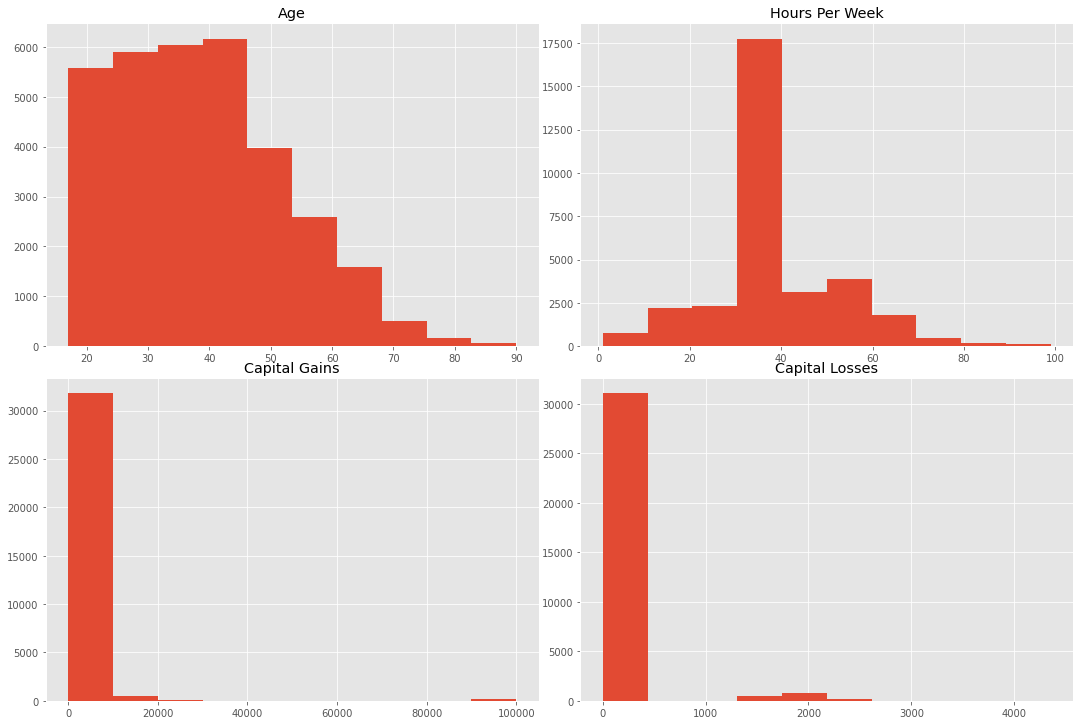

In [70]:
import matplotlib.pyplot as plt
# Matplot lib is pretty ugly, so use ggplot styling
plt.style.use("ggplot")
# Create subplot with two rows and columns with a larger plot size for ease of comparison
fig, axs = plt.subplots(2,2, figsize = (15, 10))
# Spaces the plots out so the titles don't overlap
fig.tight_layout()

# Plot age
axs[0, 0].set_title("Age")
axs[0, 0].hist(discrete_df["age"])

# Plot Hours per week
axs[0, 1].set_title("Hours Per Week")
axs[0, 1].hist(discrete_df["hours_pw"])

# Plot capital gains
axs[1, 0].set_title("Capital Gains")
axs[1, 0].hist(discrete_df["capital_gain"])

# Plot capital losses
axs[1, 1].set_title("Capital Losses")
axs[1, 1].hist(discrete_df["capital_loss"])

plt.show()


Looking at the histograms the following discretisation schemes appear logical and easily interpretable:

- Age: Divide age into bins of size 10 with a maximum of 100.
- Hours worked per week: Divide hours worked per week into bins of size 10, with a maximum of 100.
- Capital gains: Divide capital gains into bins of size 10,000 with a maximum of 100,000.
- Capital losses: Divide capital losses into bins of size 1,000 with a maximum of 5,000.

In [71]:
from discretise import discretise_age
from discretise import discretise_hours
from discretise import discretise_cap_gains
from discretise import discretise_cap_loss


discrete_df["age"] = discrete_df["age"].apply(lambda x: discretise_age(x))
discrete_df["hours_pw"] = discrete_df["hours_pw"].apply(lambda x: discretise_hours(x))
discrete_df["capital_gain"] = discrete_df["capital_gain"].apply(lambda x: discretise_cap_gains(x))
discrete_df["capital_loss"] = discrete_df["capital_loss"].apply(lambda x: discretise_cap_loss(x))


dummy_df = pd.get_dummies(discrete_df)
print(dummy_df.head())

   capital_gain_0-9K  capital_gain_10-19K  capital_gain_20-29K  \
0                  1                    0                    0   
1                  1                    0                    0   
2                  1                    0                    0   
3                  1                    0                    0   
4                  1                    0                    0   

   capital_gain_30-39K  capital_gain_40-49K  capital_gain_90-99K  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   capital_loss_0-1K  capital_loss_1-2K  capital_loss_2-3K  capital_loss_3-4K  \
0                  1                  0                  0                  0   
1                  1            

Now that the data is in the correct format we can perform apriori pruning to find the association rules. Experimenting with the dataset it was found that the maximum value for ```min_support``` that produced useful rules lay between 0.18 and 0.19, reducing the ```min_support``` below 0.18 results in highly convoluted rules that provide little insight. We are using lift as the metric as we are looking for characteristics associated with a higher income, and we are looking for a positive association, so the ```min_threshold``` value is set to ```1.01```.  

In [72]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(dummy_df, min_support=0.18, use_colnames=True) 
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.01)
print(rules.head())

              antecedents             consequents  antecedent support  \
0     (capital_gain_0-9K)              (gender_F)            0.976352   
1              (gender_F)     (capital_gain_0-9K)            0.330795   
2  (income_bracket_<=50K)     (capital_gain_0-9K)            0.759190   
3     (capital_gain_0-9K)  (income_bracket_<=50K)            0.976352   
4     (capital_gain_0-9K)             (age_20-29)            0.976352   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.330795  0.326464    0.334371  1.010813  0.003492    1.005374  
1            0.976352  0.326464    0.986909  1.010813  0.003492    1.806466  
2            0.976352  0.758760    0.999434  1.023641  0.017523   41.755474  
3            0.759190  0.758760    0.777138  1.023641  0.017523    1.080533  
4            0.247351  0.246153    0.252115  1.019261  0.004652    1.006370  


We are only interested in the rules in which having an income larger than 50K is the rule's consequent, or the outcome of the rule, so we will filter the rules to include only those where having an income greater than 50K is the only outcome.

In [73]:
def row_filter(x):
    if "income_bracket_>50K" in x["consequents"] and len(x["consequents"]) == 1:
        return True
    return False

# Add a column indicating whether the consequents only contain income >=50K
rules["income_row"] = rules.apply(lambda x: row_filter(x), axis=1)
rules = rules[rules["income_row"] == True]
rules = rules.sort_values(by=["lift"], ascending=[False])
print(len(rules))

35


Now that we have a reasonable number of association rules to examine, let's print them in a readable format and interpret them.

In [74]:
from apriori import print_rules
print_rules(rules)

(marriage_status_Married,marital_relationship_Married-civ-spouse,country_name_United-States) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.9
Antecedents count: 3


(marital_relationship_Married-civ-spouse,country_name_United-States) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.9
Antecedents count: 2


(ethnicity_White,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.89
Antecedents count: 2


(ethnicity_White,marital_relationship_Married-civ-spouse,marriage_status_Married) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.89
Antecedents count: 3


(marriage_status_Married,country_name_United-States) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.45
Lift: 1.87
Antecedents count: 2


(marriage_status_Married,marital_relationship_Married-civ-spouse,relationship_role_Husband,gender_M) -> (income_bracket_>50K)
Support: 0.18
Confidence: 0.45
Lift: 1.86
Antecedents count: 4


(marit

The top 5 rules in terms of lift appear to be convoluted and contain redundancy in terms of attributes. The first two rules differ only in that the second does not include ```marriage_status_Married```, but does include ```marital_relationship_Married-civ-spouse```, which indicates the same information, albeit more specifically. 

Given that the minimum lift threshold was set to ```1.01```, all of the mined rules indicate a positive association between the antecedents and the consequent, having an income larger than 50K per year. Therefore, to adequately answer the question of what someone seeking to increase their income should do, it is perhaps better to look at the simplest rules which are associated with a higher income, as the changes proposed by these may then be arbitrarily combined to increase the likelihood of a person earning more than \$50,000 per year.

Instead of ranking the rules by lift, we can instead list them by the number of attributes in the antecedents to identify simpler, more useful rules.  

In [75]:
rules["antecedents_count"] = rules["antecedents"].apply(lambda x: len(x))
rules = rules.sort_values(
    by=["antecedents_count", "lift"],
    ascending=[True, False]
)
print_rules(rules)

(relationship_role_Husband) -> (income_bracket_>50K)
Support: 0.18
Confidence: 0.45
Lift: 1.86
Antecedents count: 1


(marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.21
Confidence: 0.45
Lift: 1.86
Antecedents count: 1


(marriage_status_Married) -> (income_bracket_>50K)
Support: 0.21
Confidence: 0.44
Lift: 1.81
Antecedents count: 1


(gender_M) -> (income_bracket_>50K)
Support: 0.2
Confidence: 0.31
Lift: 1.27
Antecedents count: 1


(ethnicity_White) -> (income_bracket_>50K)
Support: 0.22
Confidence: 0.26
Lift: 1.06
Antecedents count: 1


(country_name_United-States) -> (income_bracket_>50K)
Support: 0.22
Confidence: 0.25
Lift: 1.02
Antecedents count: 1


(marital_relationship_Married-civ-spouse,country_name_United-States) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.9
Antecedents count: 2


(ethnicity_White,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.89
Antecedents count: 2


(

Looking at the rules ordered by the number of attributes in the antecedents, we see similar trends to the graphs produced in the first assignment. Let's take a look at the top rules containing a single antecedent and interpret them:

- Rule 1: If a person is a husband they are 1.86 times more likely to have an income greater than \$50,000. 
- Rule 2: If a person is a civilian spouse they are 1.86 times more likely to have an income greater than \$50,000.
- Rule 3: If a person is married they are 1.81 times more likely to have an income greater than \$50,000.
- Rule 4: If a person is male they are 1.27 times more likely to have an income greater than \$50,000.
- Rule 5: If a person is white they are 1.06 times more likely to have an income greater than \$50,000.
- Rule 6: If a person is born in the United States they are 1.02 times more likely to have an income greater than \$50,000.

The support for these rules ranges from 0.18 to 0.22, suggesting that there is a reasonably large number of rows containing the antecedent, consequent, or both. 

The confidence for these rules ranges from 0.25 to 0.45, demonstrating that confidence can at times be a misleading metric for analysing association rules due to the fact that is does not account for the frequency of the antecedent and the consequent in the data set.

Looking further down the list of rules we also see that there are interactions between the parameters that produce larger lift values, for example, being a civilian spouse and born in the United States makes a person 1.9 times more likely to have an income greater than \$50,000, a larger lift value than either of those characteristics produce alone.


### Answering our initial question

In the context of the analysis performed in the first part of the assignment, the rules produced by apriori pruning aren't hugely surprising and are consistent with the findings of similar studies in the [literature](https://www.jstor.org/stable/26350078?seq=1#metadata_info_tab_contents). Given that race, gender at birth, and place of birth are not characteristics that can be changed, the only practical advice that can be offered to people wishing to increase their income is to get married. 

## Classification

Binary decision trees are a simple, yet powerful classification tool that assign labels to instances in a data set by repeatedly checking if they meet a binary condition. Decision trees act as a series of if-then-else decisions that eventually assign a label to every instance in the data set. 

For this dataset the ```scikit-learn``` library will be used to produce binary decision trees for classifying whether a person earns more than \$50,000 a year. 

We will build two trees, one using a list of attributes selected on the basis of information gain, and another built from the full dataset. 

Let's start by finding the information gain of the features:

# TODO: Explain information gain

In [76]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

x_arr = discrete_df.copy()
x_arr.drop(["income_bracket"], axis=1, inplace=True)
x_arr= pd.get_dummies(x_arr)

col_names = x_arr.columns

x_arr = x_arr.values

y_arr = discrete_df["income_bracket"]
y_arr = pd.get_dummies(y_arr)

y_arr.drop(["<=50K"], axis=1, inplace=True)
y_arr = y_arr.values.ravel()


info_gain = mutual_info_classif(x_arr, y_arr)

In [77]:
result = dict(zip(col_names, info_gain))
gain_cols = []
for key, value in result.items():
    if value > 0.0:
        print(f"{key}: {value}")
        gain_cols.append(key)

capital_gain_0-9K: 0.04093985180286519
capital_gain_10-19K: 0.020036188072996675
capital_gain_20-29K: 0.0020534667372540394
capital_gain_30-39K: 0.0010478134031566277
capital_gain_90-99K: 0.004111423398020397
capital_loss_0-1K: 0.017942206004739836
capital_loss_1-2K: 0.00850090377541357
capital_loss_2-3K: 0.005093562072132407
capital_loss_3-4K: 0.0024060735736008976
capital_loss_4-5K: 0.002322414586944044
hours_pw_10-19: 0.004089981114507202
hours_pw_20-29: 0.011883862628628394
hours_pw_30-39: 0.0028445755484476365
hours_pw_40-49: 0.00026640561118185246
hours_pw_50-59: 0.009989754245989024
hours_pw_60-69: 0.0035293331218424484
gender_F: 0.022349717082968512
gender_M: 0.026276616762615612
age_10-19: 0.01394886092383052
age_20-29: 0.029833298904148764
age_30-39: 0.0019524683622373917
age_40-49: 0.012473509115575654
age_50-59: 0.007923406108228948
age_70-79: 0.00010873280464784862
age_80-89: 0.001121581055036458
age_90-99: 0.0005927833753065492
country_name_Canada: 0.0029075107077778384
c

In [78]:
# Import some tree building libraries
from sklearn import tree


# Set class names for visualisation
cn = ["<=50K", ">50K"]

# Create X and Y dataframes
y = pd.get_dummies(discrete_df["income_bracket"])
# Only need to predict on one bracket, drop less than 50K bracket
y.drop(["<=50K"], axis=1, inplace=True)

x_all = pd.get_dummies(discrete_df)
x_all = x_all.drop(["income_bracket_<=50K", "income_bracket_>50K"], axis=1)

x_sel = pd.get_dummies(discrete_df)[gain_cols]


tree_sel = tree.DecisionTreeClassifier(random_state=1)
tree_all = tree.DecisionTreeClassifier(random_state=1)

tree_sel.fit(x_sel, y)
tree_all.fit(x_all, y)


DecisionTreeClassifier(random_state=1)

For the initial construction of the trees we'll use all of the data to get an idea of what form the trees will take and we will use 10-fold cross validation to evaluate their performance later. The algorithm used by sklearn is [Classification and Regression Trees (CART)](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart), which uses the features and thresholds which maximise information gain. However, sklearn's implementation does not support categorical data, and so the data set must be converted to its binary encoding to be used. As with the association rule mining exercise, this is easily achieved with ```pd.get_dummies()```. Let's examine the trees' form and performance.

But first we need to install the ```graphviz``` library for visualising trees, if we dont already have it.

In [79]:
# import sys
# !{sys.executable} -m pip install graphviz 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.152039 to fit


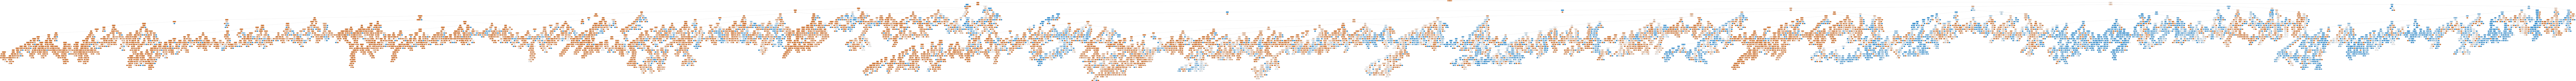

In [85]:
import graphviz 
# Import image display library for visualising trees
from IPython.display import Image

dot_data = tree.export_graphviz(tree_sel, out_file=None, feature_names=x_sel.columns, filled=True, rounded=True, class_names=cn) 
graph = graphviz.Source(dot_data)  
graph.render('big_tree', format="png")
Image(filename='big_tree.png')

I don't know about you, but that tree is a little bit too large. I also don't suggest you attempt to visualise the tree with all the attributes in the training set, it crashed my computer when I tried. Instead, we will construct multiple trees to find the maximum depth for the trees which produces the optimum results. This approach to constructing decision trees will limit overfitting by constructing several trees of varying depths and comparing their classification efficiency using cross validation. We'll evaluate trees with a depth from 2 to 50 using 10 fold cross validation and plot the results to see if there there are any trends in classification efficiency, select the best depth for both trees, train them and then compare their efficiency using 10 fold cross validation. 

In [81]:
from sklearn.model_selection import GridSearchCV
depth_range = list(range(2, 50))
params = {"max_depth": depth_range}

# use 4 cores, set 10 fold cross validation and use classification accuracy as the metric
rf_sel = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), params, n_jobs=4, cv=10, scoring="accuracy")
rf_all = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), params, n_jobs=4, cv=10, scoring="accuracy")

rf_sel.fit(x_sel, y)
rf_all.fit(x_all, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=4,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, 30, 31, ...]},
             scoring='accuracy')

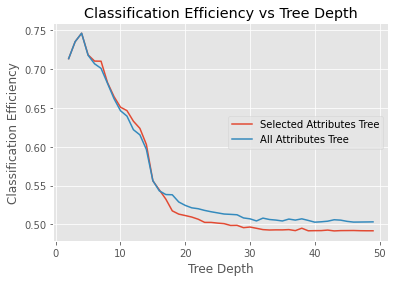

In [82]:
plt.plot(depth_range, rf_sel.cv_results_["mean_test_score"], label="Selected Attributes Tree")
plt.plot(depth_range, rf_all.cv_results_["mean_test_score"], label="All Attributes Tree")
plt.xlabel("Tree Depth")
plt.ylabel("Classification Efficiency")
plt.title("Classification Efficiency vs Tree Depth")
plt.legend(loc="center right")
plt.show()

In [83]:
print((discrete_df["income_bracket"] == "<=50K").value_counts())
print(f"Accuracy if you guess that everyone earns less than 50K: {round(24720 / len(discrete_df), 2)}")

True     24720
False     7841
Name: income_bracket, dtype: int64
Accuracy if you guess that everyone earns less than 50K: 0.76


Worryingly it appears that neither tree performs better than if we randomly guessed that everyone earns less than 50K, however we'll wait for the results of the 10 fold cross validation to be sure. In the meantime the plot reveals some interesting information. Firstly, the selected attributes tree has the same best performance as the  the all attributes tree, which was to be expected as the selected attributes tree includes only the columns which have a positive information gain, and therefore can be used to make predictions. Secondly, it is clear that the classification efficiency of both trees decreases dramatically with depth. Again, this is to be expected as deeper trees tend to be more overfitted than shallower trees.   

Let's perform 10 fold cross validation and compare their performance. 

In [84]:
from sklearn.model_selection import cross_val_score

sel_max_depth = rf_sel.best_params_["max_depth"]
all_max_depth = rf_all.best_params_["max_depth"]


opt_tree_sel = tree.DecisionTreeClassifier(random_state=1, max_depth=sel_max_depth)
opt_tree_all = tree.DecisionTreeClassifier(random_state=1, max_depth=all_max_depth)

sel_scores = cross_val_score(opt_tree_sel, x_sel, y, scoring="accuracy", cv=10)
all_scores = cross_val_score(opt_tree_sel, x_all, y, scoring="accuracy", cv=10)

print(f"Selected tree mean accuracy: {round(sel_scores.mean(), 2)}\n"
      f"Selected tree standard deviation accuracy: {round(sel_scores.std(), 2)}"
)
print(
    f"All tree mean accuracy: {round(all_scores.mean(), 2)}\n"
    f"All tree standard deviation accuracy:{round(sel_scores.std(), 2)}"
)

Selected tree mean accuracy: 0.75
Selected tree standard deviation accuracy: 0.19
All tree mean accuracy: 0.75
All tree standard deviation accuracy:0.19


It appears that neither tree has a better classification accuracy than simply guessing that everyone earns less than 50K. This inefficiency is likely due to the binary encoding applied to the dataset. As the data is binary encoded the tree is by default a binary tree, which limits the nuance with which decisions can made at each level as compared to other tree building methods such as the J48 algorithm used in the Weka tool. 

Let's fit the trees with a test-train split, check the confusion matrix and visualise them to see what went wrong. 

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

x_new = discrete_df.copy()
y_new = discrete_df["income_bracket"]

# Set random state the same so the same test-train split is taken
x_sel_train, x_sel_test, y_sel_train, y_sel_test = train_test_split(x_sel, y, test_size=0.2, random_state=1)
x_all_train, x_all_test, y_all_train, y_all_test = train_test_split(x_all, y, test_size=0.2, random_state=1)


opt_tree_sel.fit(x_sel_train, y_sel_train)
opt_tree_all.fit(x_all_train, y_all_train)

sel_pred = opt_tree_sel.predict(x_sel_test)
all_pred = opt_tree_all.predict(x_all_test)


print("Selected tree results")
print("-------------------------------------------")
print(confusion_matrix(y_sel_test, sel_pred))
print(classification_report(y_sel_test, sel_pred))

print("All tree results")
print("-------------------------------------------")
print(confusion_matrix(y_all_test, all_pred))
print(classification_report(y_all_test, all_pred))




Selected tree results
-------------------------------------------
[[4541  411]
 [ 732  829]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4952
           1       0.67      0.53      0.59      1561

    accuracy                           0.82      6513
   macro avg       0.76      0.72      0.74      6513
weighted avg       0.82      0.82      0.82      6513

All tree results
-------------------------------------------
[[4541  411]
 [ 732  829]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4952
           1       0.67      0.53      0.59      1561

    accuracy                           0.82      6513
   macro avg       0.76      0.72      0.74      6513
weighted avg       0.82      0.82      0.82      6513



Unsurprisingly the results for both models are identical, and disappointing. 

Precision is the ratio of true positives to total positives and can be thought of intuitively as the tree's ability to not label something as positive that is negative. The lower the precision the more likely it is that the tree classifies an instance positively when it's in fact negative. For both trees the precision for predicting people earning less than 50K is reasonably high, indicating that the tree is good at identifying low income records, but suffers when it comes to accurately predicting high income records. 

Recall is the ratio of true positives to true positives and false negatives, and may be thought of the classifier's ability to find positive records. The lower the recall the less likely that the tree will correctly classify a positive record for a given class. As with the precision the recall of the trees for low income records is reasonably high, again indicating it is good at identifying low income records, whilst the recall for high income records is very poor. 

These trends may also be observed in the confusion matrices where half of the high income records are misclassified, compared to just under 10% of low income records.


Looking at the ```macro avg``` row, we see that the average precision is ```0.76```, which as calculated above is not any better than classifying all records as being low income. 


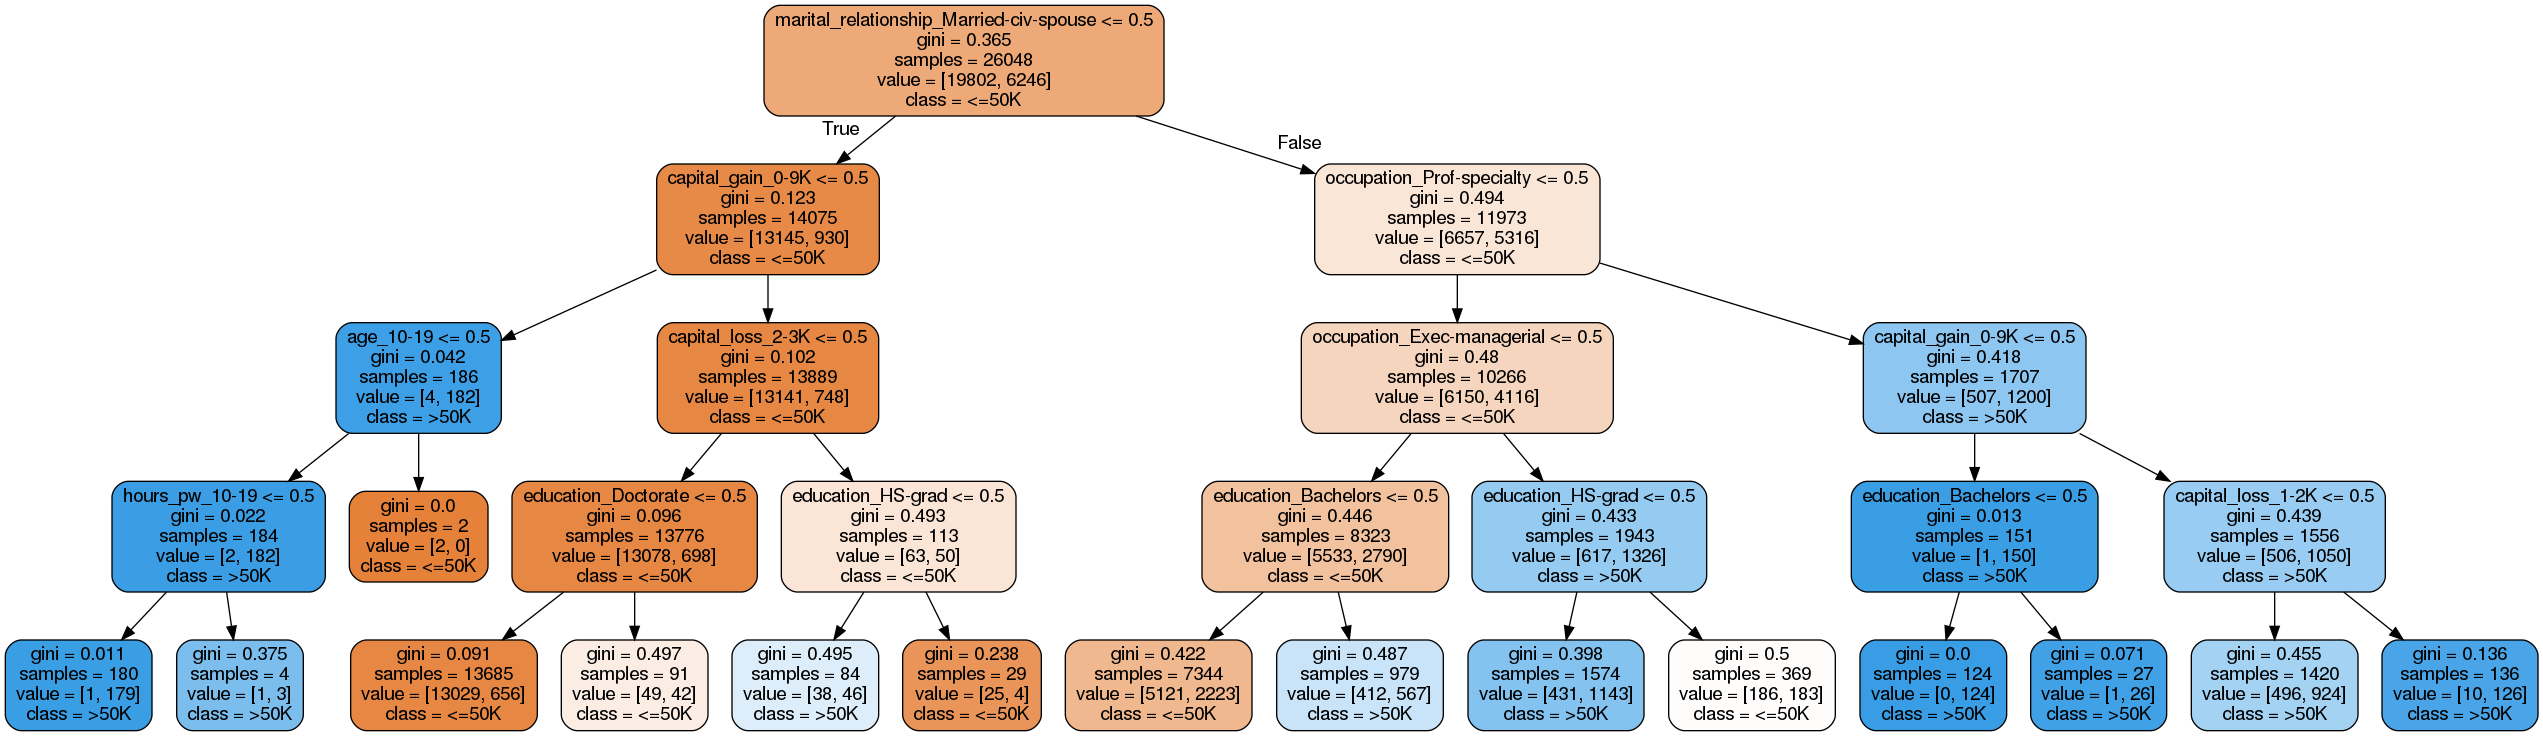

In [54]:
# Visualise the selected tree

dot_data = tree.export_graphviz(opt_tree_sel, out_file=None, feature_names=x_sel.columns, filled=True, rounded=True, class_names=cn) 
graph = graphviz.Source(dot_data)  
graph.render("selected_tree", format="png")
Image(filename='selected_tree.png')

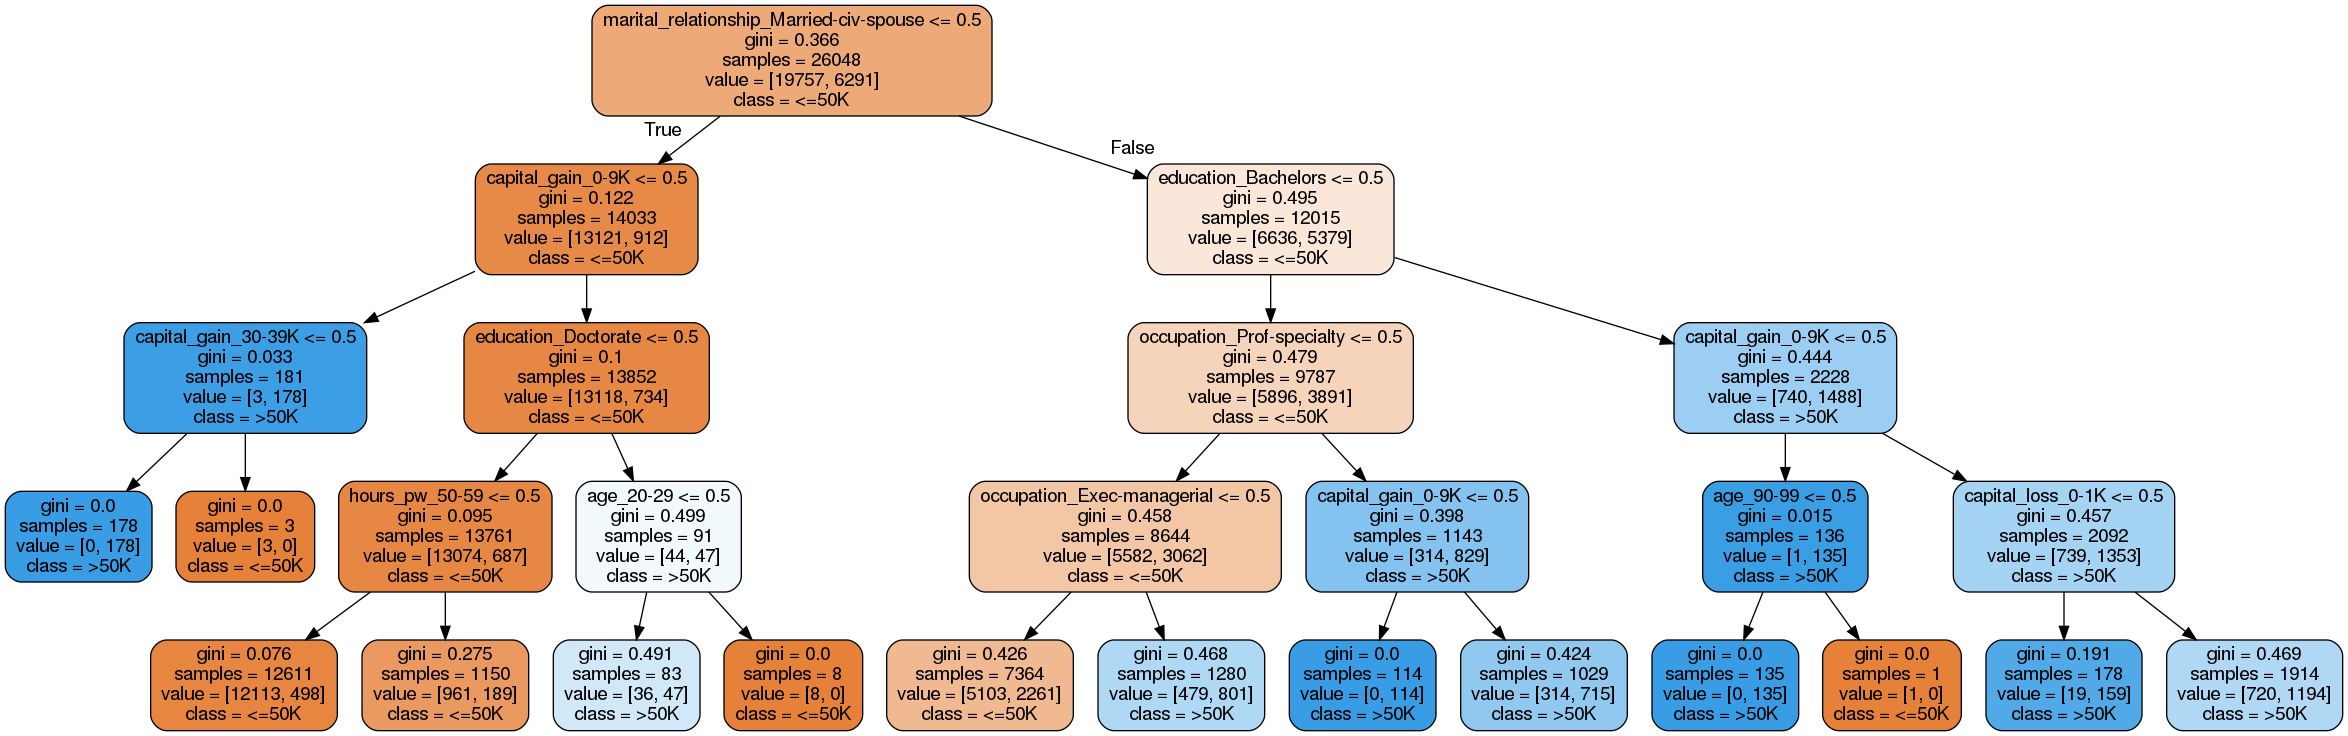

In [156]:
# Visualise the all attributes tree
dot_data = tree.export_graphviz(opt_tree_all, out_file=None, feature_names=x_all.columns, filled=True, rounded=True, class_names=cn) 
graph = graphviz.Source(dot_data)
graph.render("all_tree", format="png")
Image(filename='all_tree.png')

### Interpreting Decision Trees

Decision trees look like flowcharts, which is essentially what they are. At each level of a tree a decision is represented by an oval. Inside the oval the first line describes the decision, in our case all the attributes are binary encoded, so the decision is whether instances have the characteristic in question or not represented by ```<characteristic> <= 0.5``` where a response of "True" is interpreted as the instance not having the characteristic and a response of "False" indicating that the instance possesses the characteristic. The oval also contains the Gini index for the node, which indicates the level of impurity in the node. The Gini index represents the probability that if a random instance were chosen from the node that it would be misclassified. Thus, a Gini index of 0 indicates that all the instances in the node have been correctly classified, and higher values indicate a higher misclassification rate. Nodes also contain the number of observations of both classes that it contains, and the class that the decision tree has assigned the node. Finally the colour of a node provides a visual indicator of its Gini index, enabling fast visual comparison of nodes. 



#### Selected Tree


#### All Attributes Tree
Looking at the all attributes tree it is also quickly obvious why it is a better 
